In [69]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import time
from acquire import player_season_3pa

# Endpoints from NBA API
from nba_api.stats.endpoints import playbyplayv2
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp

# Static Imports from NBA API
from nba_api.stats.static import players
from nba_api.stats.static import teams

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.cluster import KMeans

# Helpful Stuff
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Using Malik Beasley for exploratory on the new acquire function:

In [70]:
df_Beasley = player_season_3pa('Malik Beasley')

Loading game 79 of 79

In [3]:
#here it be:
df_Beasley.head()

,win_prob,abs_time,game_id,player_id,player,team_id,team,period,shot_result,shot_type,fg_type,loc_x,loc_y,zone,home,score_margin,points,fg_pct
0,0.75418,448,22100008,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,1,Missed Shot,Pullup Jump shot,3PT Field Goal,-40,247,R Above Break,True,8,0,1.00
2,0.82758,734,22100008,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Missed Shot,Jump Shot,3PT Field Goal,-186,162,R Center,True,11,2,0.50
3,0.79906,783,22100008,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Missed Shot,Jump Shot,3PT Field Goal,-104,226,R Below Break/Corner,True,9,2,0.33
5,0.97475,1361,22100008,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,2,Made Shot,Jump Shot,3PT Field Goal,-168,180,R Center,True,23,5,0.20
4,0.94672,2416,22100031,1627736,Malik Beasley,1610612750,Minnesota Timberwolves,4,Missed Shot,Jump Shot,3PT Field Goal,-94,253,R Below Break/Corner,True,12,6,0.75


In [4]:
#looking at Beasley's info:
df_Beasley.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 8
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   win_prob      634 non-null    float64
 1   abs_time      690 non-null    int64  
 2   game_id       690 non-null    int64  
 3   player_id     690 non-null    int64  
 4   player        690 non-null    object 
 5   team_id       690 non-null    int64  
 6   team          690 non-null    object 
 7   period        690 non-null    int64  
 8   shot_result   690 non-null    object 
 9   shot_type     690 non-null    object 
 10  fg_type       690 non-null    object 
 11  loc_x         690 non-null    int64  
 12  loc_y         690 non-null    int64  
 13  zone          690 non-null    object 
 14  home          690 non-null    bool   
 15  score_margin  690 non-null    int64  
 16  points        690 non-null    int64  
 17  fg_pct        690 non-null    float64
dtypes: bool(1), float64(2), int64(9)

_____________________

### Overall snapshot of Beasley's 3pt shots of the 2021-22 Season

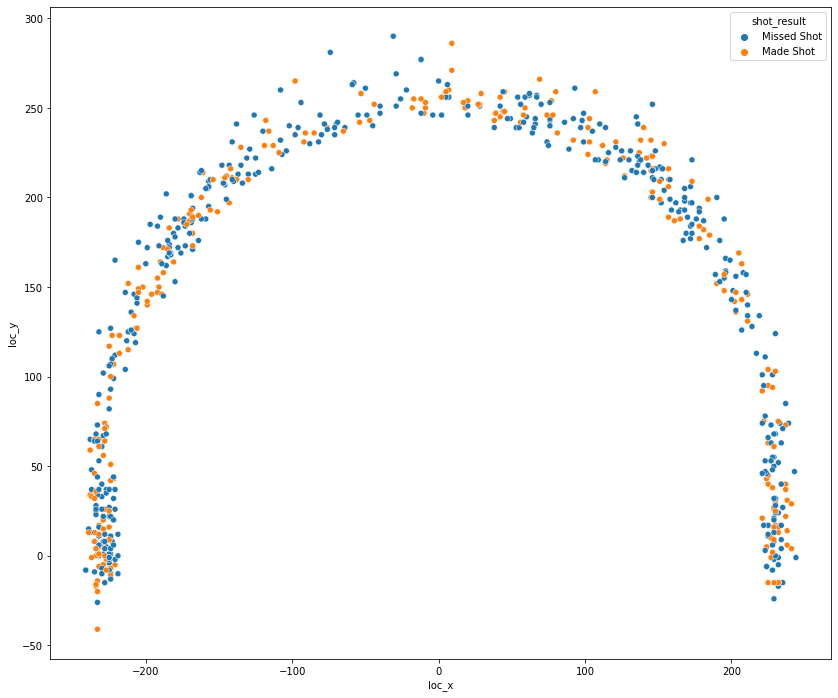

In [5]:
#plotting these all of Malik's 3pt attempts for the season:
plt.figure(figsize = (14,12))
sns.scatterplot(data =df_Beasley, x='loc_x', y = 'loc_y', hue = 'shot_result')
plt.show()

___________

### Additions for data prep:

In [6]:
#replacing shot_result string to only say 'missed' and 'made'
df_Beasley.shot_result = df_Beasley.shot_result.replace({'Missed Shot':'Missed', 'Made Shot':'Made'})

In [7]:
#creating a column of shot_result to made = 1, missed = 0 for charts-sake:
dummy_df = pd.get_dummies(df_Beasley[['shot_result','zone']], dummy_na=False)

In [8]:
df = pd.concat([df_Beasley, dummy_df], axis = 1)

In [9]:
#creating a numbered bool column for home/visitor:
df['is_home'] = df.home.astype(int)

In [10]:
### To add in bivariates: score_margin & home:

_____________________

### Univariate Exploration:

#### Key Takeaways:
Beasley's plays have a normal distribution when it comes to his score margin and the count of 3pt shots he makes per period/quarter.

- There is significant patterns within what times the 3pt shots are happening (maybe this could be at the beginning or ending of the quarters?)
- The location variables show sections where Beasley seems to shoot from more often than others.
- Beasley's overall game points are also right-skewed.

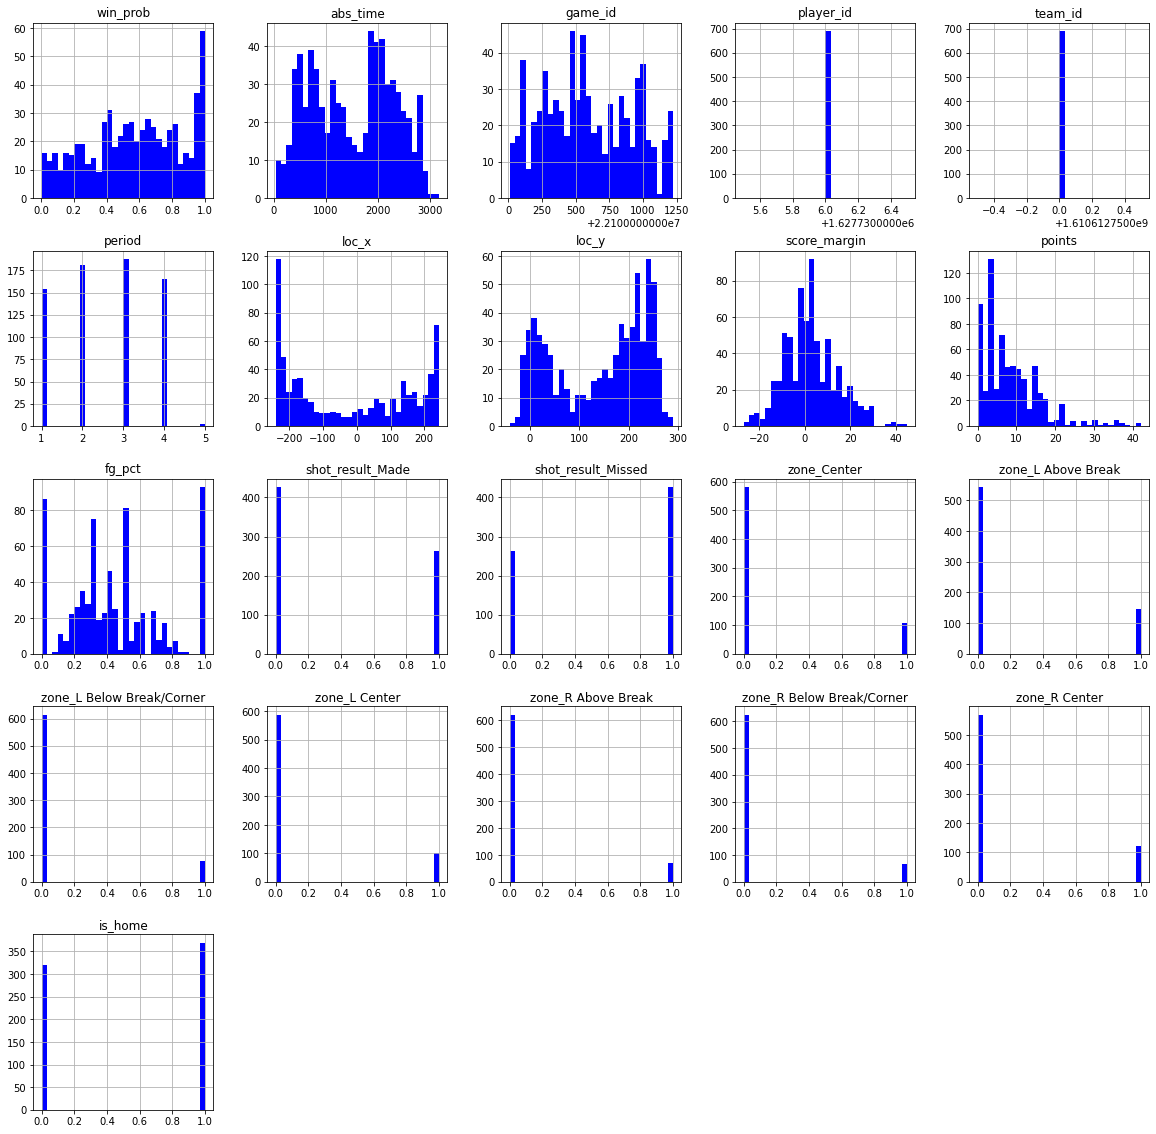

In [11]:
def univariate():
    df.hist(bins = 30, figsize = (20, 20), color= 'blue')
    
univariate()

### Bivariate Exploratory Analysis:

### 1. What is the relationship of zone to shot_result?

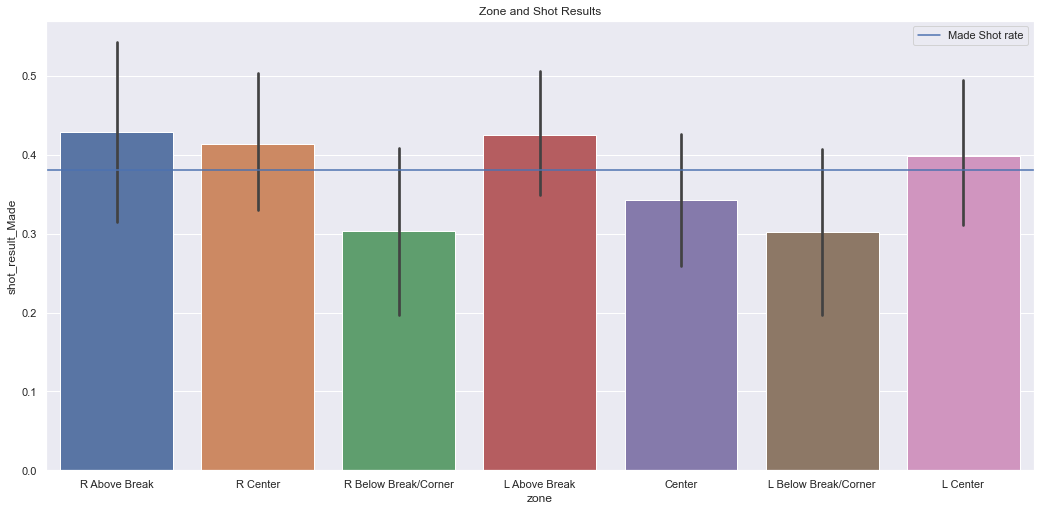

In [12]:
sns.set(rc={'figure.figsize':(17.7,8.27)})


plt.title("Zone and Shot Results")
sns.barplot(x="zone", y="shot_result_Made", data=df)
shot_result_rate = df.shot_result_Made.mean()
plt.axhline(shot_result_rate, label="Made Shot rate")
plt.legend()
plt.show()

In [63]:
df.zone.value_counts()

L Above Break           146
R Center                121
Center                  108
L Center                103
L Below Break/Corner     76
R Above Break            70
R Below Break/Corner     66
Name: zone, dtype: int64

### 2. What is the relationship of period/quarter in game to shot_result?

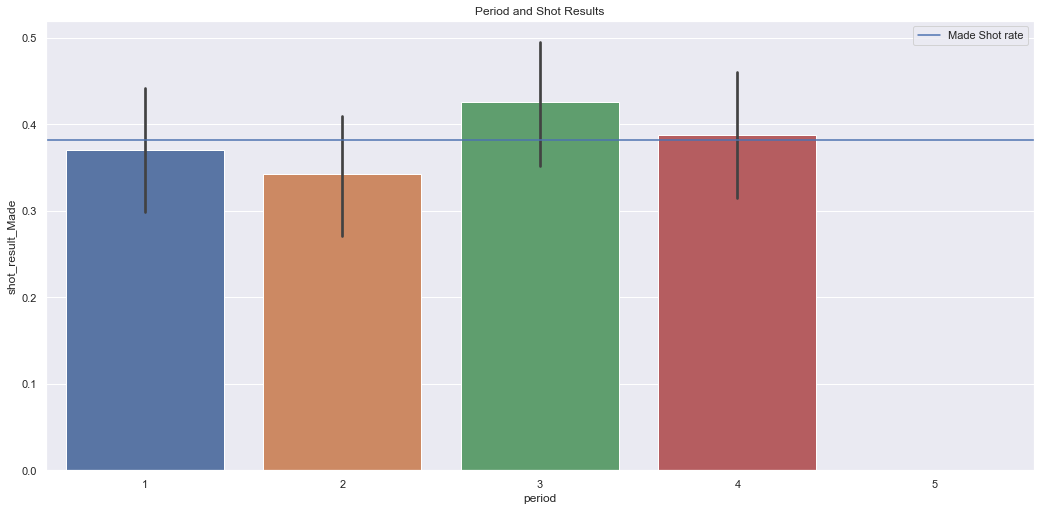

In [13]:
plt.title("Period and Shot Results")
sns.barplot(x="period", y="shot_result_Made", data=df)
shot_result_rate = df.shot_result_Made.mean()
plt.axhline(shot_result_rate, label="Made Shot rate")
plt.legend()
plt.show()

### 3. What is the relationship of shot_type to shot_result?

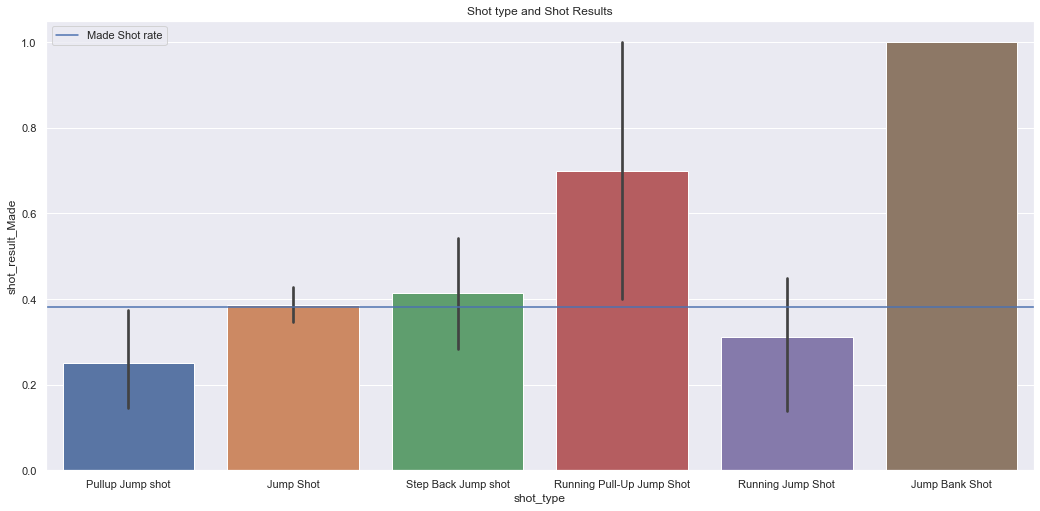

In [14]:
plt.title("Shot type and Shot Results")
sns.barplot(x="shot_type", y="shot_result_Made", data=df)
shot_result_rate = df.shot_result_Made.mean()
plt.axhline(shot_result_rate, label="Made Shot rate")
plt.legend()
plt.show()

In [15]:
df.shot_result_Made.mean()

0.38115942028985506

In [16]:
#looking at why the high rate for the Jump Bank shot....only one shot was made for this shot type:
df.shot_type.value_counts()

Jump Shot                    556
Pullup Jump shot              48
Step Back Jump shot           46
Running Jump Shot             29
Running Pull-Up Jump Shot     10
Jump Bank Shot                 1
Name: shot_type, dtype: int64

### 4. What is the relationship of score_margin to made shots?

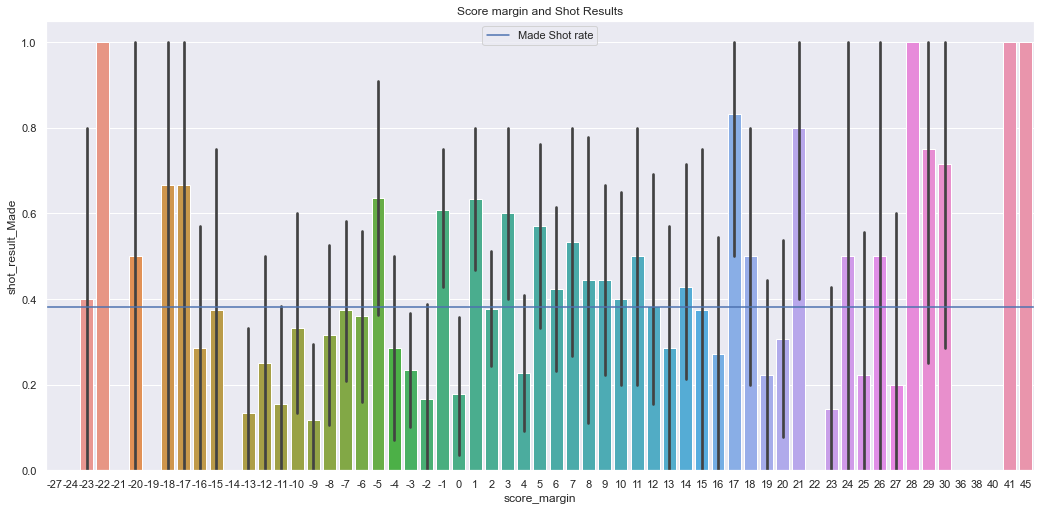

In [17]:
plt.title("Score margin and Shot Results")
sns.barplot(x="score_margin", y="shot_result_Made", data=df)
shot_result_rate = df.shot_result_Made.mean()
plt.axhline(shot_result_rate, label="Made Shot rate")
plt.legend()
plt.show()

### 5. What is the relationship of home/visitor games to made shots?

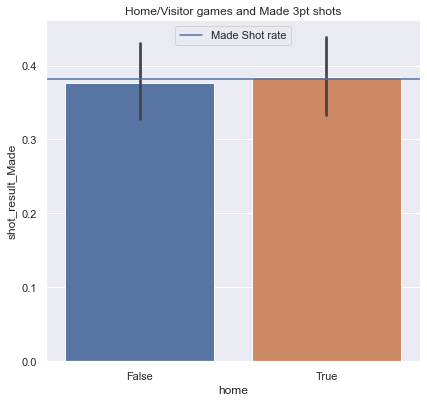

In [18]:
sns.set(rc={'figure.figsize':(6.7,6.27)})

plt.title("Home/Visitor games and Made 3pt shots")
sns.barplot(x="home", y="shot_result_Made", data=df)
shot_result_rate = df.shot_result_Made.mean()
plt.axhline(shot_result_rate, label="Made Shot rate")
plt.legend()
plt.show()

In [19]:
df.home.value_counts()

True     369
False    321
Name: home, dtype: int64

________________

### Multivariate Exploratory analysis:

#### Looking at Beasley's points made and at what time (on average) in the game the points were made:

In [40]:
#plotting data for shots in season:
shotsSeason = df_Beasley[['abs_time','points','zone','fg_pct','score_margin','period']].drop_duplicates()

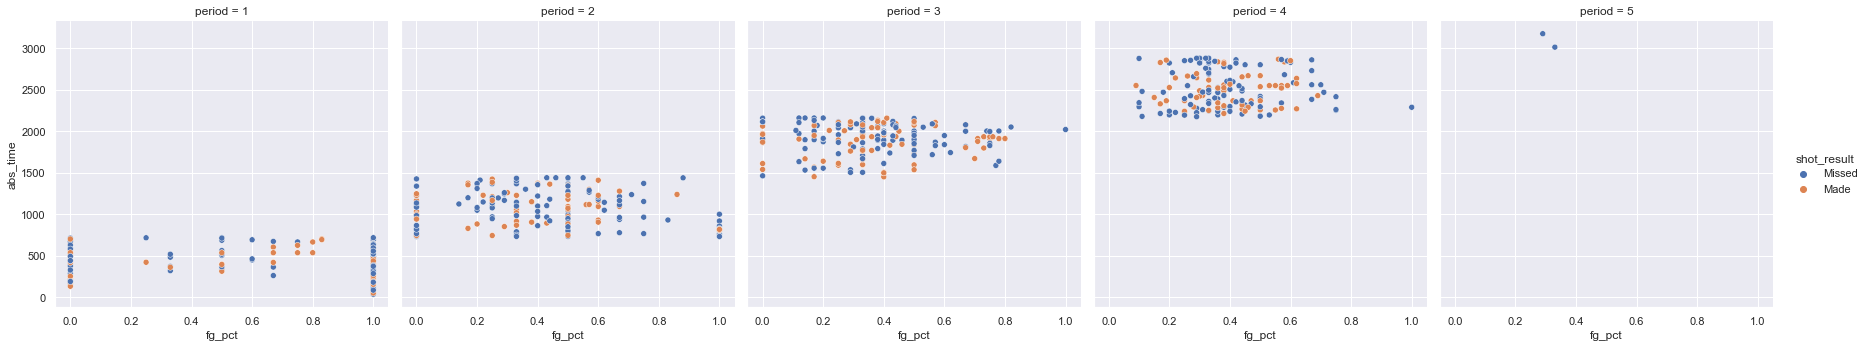

In [56]:
sns.set(rc={'figure.figsize':(17.7,8.27)})
sns.relplot(data=df, x="fg_pct", y="abs_time", hue="shot_result",col="period")

In [ ]:
df

In [ ]:
# plot the data
    df.set_index('k').plot(figsize = (16,9))
    plt.ylabel('Accuracy')

    plt.vlines(x= 10, ymin=0, ymax=1, linestyles='dashed')
    plt.xticks(np.arange(0,21,1))
    plt.grid()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 8
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   win_prob                   634 non-null    float64
 1   abs_time                   690 non-null    int64  
 2   game_id                    690 non-null    int64  
 3   player_id                  690 non-null    int64  
 4   player                     690 non-null    object 
 5   team_id                    690 non-null    int64  
 6   team                       690 non-null    object 
 7   period                     690 non-null    int64  
 8   shot_result                690 non-null    object 
 9   shot_type                  690 non-null    object 
 10  fg_type                    690 non-null    object 
 11  loc_x                      690 non-null    int64  
 12  loc_y                      690 non-null    int64  
 13  zone                       690 non-null    object 
 

____________________________________________________

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 0 to 8
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   win_prob                   634 non-null    float64
 1   abs_time                   690 non-null    int64  
 2   game_id                    690 non-null    int64  
 3   player_id                  690 non-null    int64  
 4   player                     690 non-null    object 
 5   team_id                    690 non-null    int64  
 6   team                       690 non-null    object 
 7   period                     690 non-null    int64  
 8   shot_result                690 non-null    object 
 9   shot_type                  690 non-null    object 
 10  fg_type                    690 non-null    object 
 11  loc_x                      690 non-null    int64  
 12  loc_y                      690 non-null    int64  
 13  zone                       690 non-null    object 
 